In [2]:
#!pip install xgboost
from xgboost import XGBRegressor, plot_importance
import statsmodels as sm
#https://www.statsmodels.org/dev/vector_ar.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set()
import datetime as dt
import warnings
warnings.simplefilter('ignore')
from sklearn import (linear_model, metrics, neural_network, pipeline, preprocessing, model_selection)

In [3]:
train_df = pd.read_csv('/Users/aashrit/Documents/Masters/MY498/Data/Time Series/twitter_reddit_time_series_copy2.csv')
train_df = train_df.set_index('date')
#train = train.iloc[20:,:]
train_df

,overall_sentiment_score_20d_lag,overall_attention_score_20d_lag,BEIR,interest_rate_1yr_lag,commodities_1yr_lag,UNRATENSA_1yr_lag,UMCSENT_2wk_lag,WM2NS_1yr_lag,gdp_1yr_lag
date,,,,,,,,,
01/06/2021,26.4459,3.900597,2.460,0.05,99.875276,11.2,82.9,17915.4,19477.444
02/06/2021,51.3641,2.348224,2.440,0.06,99.875276,11.2,82.9,17915.4,19477.444
03/06/2021,48.4431,1.156789,2.420,0.06,99.875276,11.2,82.9,17915.4,19477.444
04/06/2021,17.4456,0.903695,2.400,0.06,99.875276,11.2,82.9,17915.4,19477.444
05/06/2021,28.1433,0.947890,2.400,0.07,99.875276,11.2,82.9,17915.4,19477.444
...,...,...,...,...,...,...,...,...,...
27/05/2022,-56.0960,2.735565,2.630,0.06,155.100579,5.5,58.4,20235.1,22740.959
28/05/2022,-4.0143,1.563207,2.630,0.05,155.100579,5.5,58.4,20235.1,22740.959
29/05/2022,1.4806,3.380288,2.630,0.05,155.100579,5.5,58.4,20235.1,22740.959


In [4]:
nobs = 31
df_train, df_test = train_df[0:-nobs], train_df[-nobs:]

In [5]:
X_train = df_train.drop(['BEIR'],axis=1)
y_train = df_train['BEIR']
X_test = df_test.drop(['BEIR'],axis=1)
y_test = df_test['BEIR']

In [6]:
def train_test_plot(model, X_train, X_test):
    """
    This will plot the actual values of CPI against the one fitted by the model
    We train the model until 2009 and then use it from 2009 onwards on the test features dataset
    """
    fig, ax = plt.subplots(figsize=(12,4))
    colors = sns.color_palette("deep", 8)
    
    yvalues = pd.DataFrame(y_test)
    
    forecasted = list(model.predict(X_test)) # Use the model fit on features data from 2009 onwards
    df_fcast = pd.DataFrame({"date": list(yvalues.index), "BEIR_fcast": forecasted})
    df_fcast = df_fcast.set_index("date")
    
    df = pd.merge(yvalues, df_fcast, left_index=True, right_index=True)

    df["BEIR_fcast"].plot(ax=ax, legend=True, linewidth=2.5, linestyle="dashed", color="forestgreen") # CPI fitted
    df["BEIR"].plot(ax=ax, legend=True, linewidth=1.5, linestyle="solid", color="salmon") # Actual CPI values
    
    ax.set_title("BEIR vs. Model's BEIR")
    ax.set_ylabel("BEIR")
    ax.legend(["Forecasted BEIR","Actual BEIR"])

### No HP Optimisation

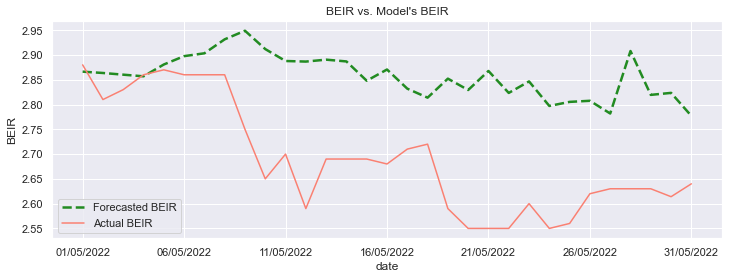

In [7]:
# Build XGBoost
# Normalize the features 
scaler = preprocessing.StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

train_test_plot(model=xgb, X_train=X_train_scaled, X_test=X_test_scaled)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

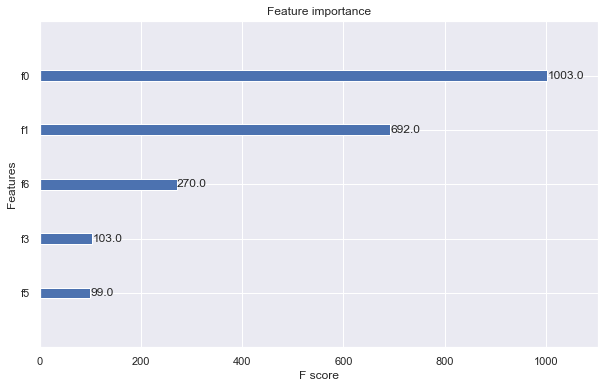

In [8]:
fig_xgb, ax_xgb = plt.subplots(figsize=(10,6))
plot_importance(xgb, max_num_features=5, ax=ax_xgb)

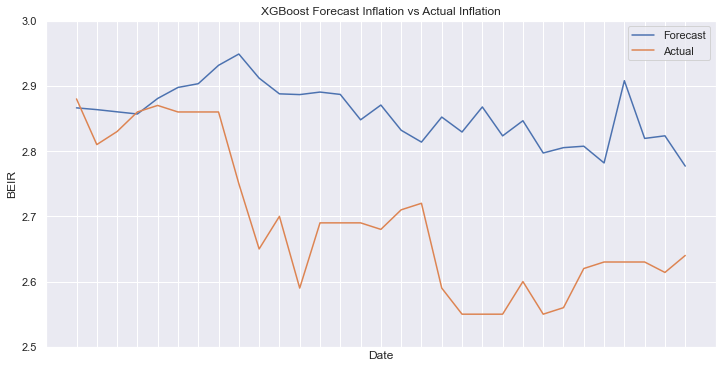

In [21]:
plt.figure(figsize=(12,6))
plt.plot(df_test.index, xgb.predict(X_test_scaled), label = "Forecast")
# plotting the line 2 points 
plt.plot(df_test.index, y_test, label = "Actual")
plt.xlabel('Date')
# Set the y axis label of the current axis.
plt.ylabel('BEIR')
# Set a title of the current axes.
plt.title('XGBoost Forecast Inflation vs Actual Inflation')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylim(2.5,3)
# show a legend on the plot
plt.legend()
plt.savefig('xgboost_forecast.png')
# Display a figure.
plt.show()

In [9]:
for i, name in dict(zip(list(range(len(X_train.columns))), list(X_train.columns.values))).items():
    if i == 0:
        print(f"Feature {i} is {name}")
    elif i == 1:
        print(f"Feature {i} is {name}")
    elif i == 6:
        print(f"Feature {i} is {name}")
    elif i == 3:
        print(f"Feature {i} is {name}")
    elif i == 5:
        print(f"Feature {i} is {name}")

Feature 0 is overall_sentiment_score_20d_lag
Feature 1 is overall_attention_score_20d_lag
Feature 3 is commodities_1yr_lag
Feature 5 is UMCSENT_2wk_lag
Feature 6 is WM2NS_1yr_lag


In [22]:
rmse = metrics.mean_squared_error(y_test, xgb.predict(X_test), squared = False)
error = (rmse/np.mean(y_test))*100
print(rmse)
print(error)
#We see that the RMSE is quite low compared to the mean (4.5% of the size of the mean overall), 
#which means that XGBoost did quite a good job at predicting the values of the test set. 

0.1209058624080025
4.493348520210129


### With Grid Search

In [23]:
from sklearn.model_selection import GridSearchCV

xgb_opt = XGBRegressor()

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
learning_rate = [i for i in np.arange(0.001,0.1,0.001)]

grid = {'n_estimators': n_estimators,

'max_depth': max_depth,

'learning_rate': learning_rate}

xgb_opt_grid = GridSearchCV(estimator = xgb_opt, param_grid = grid, cv = 5, n_jobs = -1)

xgb_opt_grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...
                                           0.013000000000000001,
                                           0.014000000000000002, 0.015, 0.016,
                                           0.017, 0.018000000000000002,
                                        

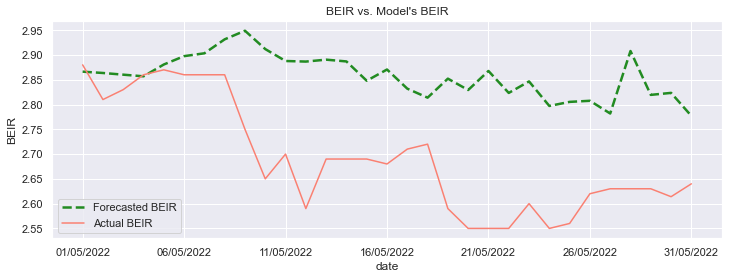

In [24]:
xgb_opt.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

train_test_plot(model=xgb_opt, X_train=X_train_scaled, X_test=X_test_scaled)

In [25]:
rmse_xgb_opt = metrics.mean_squared_error(y_test, xgb_opt.predict(X_test), squared = False)
error_xgb_opt = (rmse_xgb_opt/np.mean(y_test))*100
print(rmse_xgb_opt)
print(error_xgb_opt)
#We see that the RMSE is quite low compared to the mean (4.5% of the size of the mean overall), 
#which means that XGBoost did quite a good job at predicting the values of the test set. 

0.1209058624080025
4.493348520210129


In [26]:
##n_estimators
#max_depth
#learning_rate

### With Random Search

In [27]:
from sklearn.model_selection import RandomizedSearchCV

xgb_rand_opt = XGBRegressor()

n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
learning_rate = [i for i in np.arange(0.001,0.1,0.001)]

grid = {'n_estimators': n_estimators,

'max_depth': max_depth,

'learning_rate': learning_rate}

xgb_rand_opt_grid = RandomizedSearchCV(estimator = xgb_rand_opt, param_distributions = grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

xgb_rand_opt_grid.fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                                          0.014000000000000002,
                          

In [28]:
xgb_rand_opt_grid.best_params_

{'n_estimators': 17, 'max_depth': 60, 'learning_rate': 0.098}

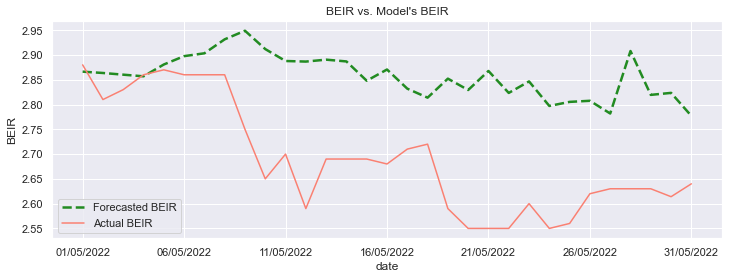

In [31]:
xgb_rand_opt.fit(X_train_scaled, y_train)

X_test_scaled = scaler.transform(X_test)

train_test_plot(model=xgb_rand_opt, X_train=X_train_scaled, X_test=X_test_scaled)

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(df_test.index, xgb_rand_opt.predict(X_test_scaled), label = "Forecast")
# plotting the line 2 points 
plt.plot(df_test.index, y_test, label = "Actual")
plt.xlabel('Date')
# Set the y axis label of the current axis.
plt.ylabel('BEIR')
# Set a title of the current axes.
plt.title('XGBoost Forecast Inflation vs Actual Inflation')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.ylim(2.5,3)
# show a legend on the plot
plt.legend()
plt.savefig('xgboost_forecast.png')
# Display a figure.
plt.show()

In [32]:
rmse_xgb_rand_opt = metrics.mean_squared_error(y_test, xgb_rand_opt.predict(X_test), squared = False)
error_xgb_rand_opt = (rmse_xgb_rand_opt/np.mean(y_test))*100
print(rmse_xgb_rand_opt)
print(error_xgb_rand_opt)
#We see that the RMSE is quite low compared to the mean (4.5% of the size of the mean overall), 
#which means that XGBoost did quite a good job at predicting the values of the test set. 

0.1209058624080025
4.493348520210129
